<a href="https://colab.research.google.com/github/Uswatyusuff/Project2_C24/blob/main/CSRNET_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount your Google Drive to the Colab environment
# This allows you to access files stored in your Drive (read/write)
# Files will be accessible under the '/content/gdrive' directory
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch


/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch


In [ ]:
# installing libraries
!pip install opencv-python
!pip install image
!pip install torch torchvision


# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
import torch
from tqdm import tqdm
%matplotlib inline


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 70.7 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=09a52b416a64717ae325a8900c0401bc0013ec0577cdbb4a023fb25c3c609ddd
  Stored in directory: /root/.cache/pip/wheels/62/40/4f/3c9a8d0f22a1a6f966975a460e5cb509a1e7dc42e2ce5d9a6d
Successfully built image
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<ipython-input-5-10de9d70ab8b>:14: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [ ]:
# Import the CSRNet model architecture from the model module
# This is the convolutional neural network used for crowd counting via density maps
from model import CSRNet

In [ ]:
# Open the JSON configuration file named 'grid_config.json' in read mode
with open('grid_config.json') as f:
    # Load the contents of the JSON file into a Python dictionary called 'config'
    config = json.load(f)


In [ ]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [ ]:
# Define the root directory where your project and datasets are stored
root = "/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch"

# Construct the full path to the training images folder
train_data = os.path.join(root, 'Shangai_Tech/train_data', 'images')

# Construct the full path to the testing images folder
test_data = os.path.join(root, 'Shangai_Tech/test_data', 'images')

# Combine both train and test paths into a list for easy iteration or processing
path_sets = [train_data, test_data]


In [ ]:
#setting image locations
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.JPG')):
        img_paths.append(img_path)
#creating density map for each image
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.JPG','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    # Check if 'image_info' key exists in the mat dictionary
    if 'image_info' in mat:
        gt = mat["image_info"][0,0][0,0][0]
    # If not, check for other potential keys (e.g., 'annPoints')
    elif 'annPoints' in mat:
        gt = mat['annPoints']
    else:
        # Handle the case where neither key is found
        print(f"Error: Neither 'image_info' nor 'annPoints' found in {img_path}")
        continue  # Skip to the next image
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01305.JPG
Error: Neither 'image_info' nor 'annPoints' found in /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01305.JPG
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01306.JPG
Error: Neither 'image_info' nor 'annPoints' found in /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01306.JPG
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01307.JPG
Error: Neither 'image_info' nor 'annPoints' found in /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01307.JPG
/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01308.JPG
Error: Neither 'image_info' nor 'annPoints' found in /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images/DSC01308.JPG
/content/gdr

KeyboardInterrupt: 

In [ ]:
# Import necessary modules
import os
import json

def create_image_list_json(directory, output_json="image_paths.json"):
    """
    Scans a directory for image files and saves their absolute paths to a JSON file.

    Args:
        directory (str): Path to the folder containing image files.
        output_json (str): Filename for the output JSON (default: 'image_paths.json').
    """

    # Define supported image file extensions
    valid_extensions = (".jpg", ".jpeg", ".png")

    # Get absolute paths of all valid image files in the specified directory
    image_paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.lower().endswith(valid_extensions)
    ]

    # Save the list of image paths to a JSON file
    with open(output_json, "w") as json_file:
        json.dump(image_paths, json_file, indent=4)

    print(f"✅ JSON file saved: {output_json}")

# Example usage of the function
image_directory = "/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad/train_grad/images"
output_file = "/content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad_train.json"

# Generate the JSON file containing all image paths in the directory
create_image_list_json(image_directory, output_file)


JSON file saved: /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch/grad_train.json


In [ ]:
# Change the current working directory to the CSRNet project folder in Google Drive
%cd /content/gdrive/MyDrive/CSRNET_Project_Folder/CSRNet-pytorch

# Run the training script with specified arguments:
# - train.json: JSON file listing training data
# - test.json: JSON file listing validation/test data
# - --gpu 0: Use GPU device 0 (set to -1 for CPU)
# - --task 0: Task ID or custom flag defined in the training script (usually refers to the dataset or training mode)
!python train.py train.json test.json --gpu 0 --task 0


Streaming output truncated to the last 5000 lines.
Epoch [83], Step [990/2744], Loss: 25.1343
Epoch [83], Step [1000/2744], Loss: 37.2714
Epoch [83], Step [1010/2744], Loss: 7.1591
Epoch [83], Step [1020/2744], Loss: 15.7131
Epoch [83], Step [1030/2744], Loss: 90.2635
Epoch [83], Step [1040/2744], Loss: 30.7403
Epoch [83], Step [1050/2744], Loss: 0.5803
Epoch [83], Step [1060/2744], Loss: 8.4107
Epoch [83], Step [1070/2744], Loss: 0.2972
Epoch [83], Step [1080/2744], Loss: 77.8156
Epoch [83], Step [1090/2744], Loss: 43.0659
Epoch [83], Step [1100/2744], Loss: 43.6168
Epoch [83], Step [1110/2744], Loss: 10.5069
Epoch [83], Step [1120/2744], Loss: 0.6382
Epoch [83], Step [1130/2744], Loss: 2.7834
Epoch [83], Step [1140/2744], Loss: 40.1059
Epoch [83], Step [1150/2744], Loss: 74.2991
Epoch [83], Step [1160/2744], Loss: 22.5385
Epoch [83], Step [1170/2744], Loss: 1.3294
Epoch [83], Step [1180/2744], Loss: 6.2548
Epoch [83], Step [1190/2744], Loss: 17.1080
Epoch [83], Step [1200/2744], Loss

In [ ]:

import subprocess
import random
import time

# Define the hyperparameter search space
learning_rates = [1e-6, 1e-7]      # List of learning rates to try
batch_sizes = [1, 2, 4]            # List of batch sizes to try
epochs_list = [50, 100]           # List of epoch counts to try

# Total number of different random combinations to run
n_trials = 3

# Set to store combinations already tried to avoid duplicates
tried = set()

# Loop for the number of desired trials
for trial in range(n_trials):
    while True:
        # Randomly pick one value from each hyperparameter list
        lr = random.choice(learning_rates)
        bs = random.choice(batch_sizes)
        ep = random.choice(epochs_list)

        # Skip this combination if already tried
        if (lr, bs, ep) not in tried:
            tried.add((lr, bs, ep))  # Mark this combination as tried
            break  # Exit loop when a new combo is found

    # Create a unique name for the task based on the current parameters
    task_name = f"rand_lr{lr}_bs{bs}_ep{ep}"
    print(f"\n🚀 Random Trial {trial+1}/{n_trials}: {task_name}")

    # Build the command string to run the training script with the selected hyperparameters
    cmd = f"""
    python train.py train.json test.json \
        --task {task_name} \
        --epochs {ep} \
        --batch_size {bs} \
        --lr {lr} \
        --early_stop_patience 10 \
        --gpu 0
    """

    # Launch the command as a subprocess
    process = subprocess.Popen(
        cmd, shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True  # Capture output as text instead of bytes
    )

    # Stream the output line by line in real-time
    for line in process.stdout:
        print(line.strip())

    # Wait for the process to complete before continuing
    process.wait()

    # Sleep to give a short break between trials
    time.sleep(2)


Streaming output truncated to the last 5000 lines.
Epoch [13], Step [2020/2744], Loss: 6.1777
Epoch [13], Step [2030/2744], Loss: 67.3261
Epoch [13], Step [2040/2744], Loss: 1.5319
Epoch [13], Step [2050/2744], Loss: 49.7900
Epoch [13], Step [2060/2744], Loss: 89.0996
Epoch [13], Step [2070/2744], Loss: 0.4984
Epoch [13], Step [2080/2744], Loss: 16.4085
Epoch [13], Step [2090/2744], Loss: 31.8319
Epoch [13], Step [2100/2744], Loss: 178.4632
Epoch [13], Step [2110/2744], Loss: 1.1837
Epoch [13], Step [2120/2744], Loss: 2.8989
Epoch [13], Step [2130/2744], Loss: 11.0846
Epoch [13], Step [2140/2744], Loss: 6.8359
Epoch [13], Step [2150/2744], Loss: 6.2586
Epoch [13], Step [2160/2744], Loss: 13.9804
Epoch [13], Step [2170/2744], Loss: 43.0434
Epoch [13], Step [2180/2744], Loss: 64.3741
Epoch [13], Step [2190/2744], Loss: 8.3216
Epoch [13], Step [2200/2744], Loss: 1079.9547
Epoch [13], Step [2210/2744], Loss: 89.0847
Epoch [13], Step [2220/2744], Loss: 154.3257
Epoch [13], Step [2230/2744],

Predicted Count :  1588


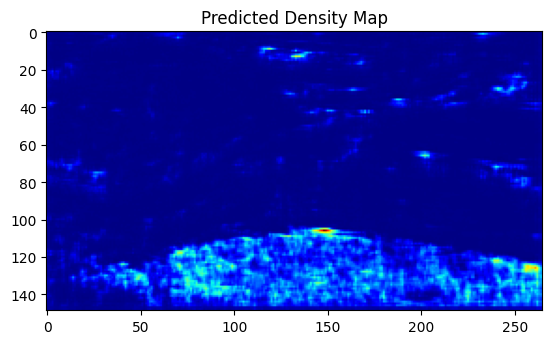

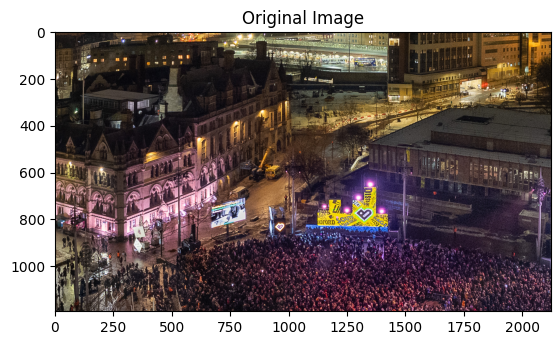

In [ ]:
# Load and preprocess the image
# - Reads the image from disk
# - Converts it to RGB
# - Applies the transform pipeline (e.g., resizing, normalization, tensor conversion)
# - Moves the tensor to the GPU using .cuda()
img = transform(Image.open('/content/patch_1_1.png').convert('RGB')).cuda()

# Run the model inference without tracking gradients (faster and uses less memory)
with torch.no_grad():
    # Add batch dimension (unsqueeze) and pass the image through the model
    output = model(img.unsqueeze(0))

# Calculate the predicted count by summing over the entire output (density map)
# - Detach the tensor from the computation graph
# - Move it back to the CPU
# - Convert it to a NumPy array and sum all values
predicted_count = int(output.detach().cpu().sum().numpy())
print("Predicted Count : ", predicted_count)

# Display the predicted density map
# - Convert the output tensor to a NumPy array
# - Reshape it to 2D (height × width)
# - Visualize it using a color heatmap (jet colormap)
density_map = np.asarray(output.detach().cpu().reshape(
    output.detach().cpu().shape[2],
    output.detach().cpu().shape[3]
))
plt.imshow(density_map, cmap=plt.cm.jet)
plt.title("Predicted Density Map")
plt.show()

# Optionally, display the original image for comparison
original_img = plt.imread('/content/patch_1_1.png')
plt.imshow(original_img)
plt.title("Original Image")
plt.show()
